- generalize goal to multiple kind of task

not yet
- looping back
- whole channel support
- RAG file search
- learning from human feedback (remembers lessons learned)

In [2]:
import os
import json
import base64
from typing import TypedDict, List, Dict, Any, Optional, Literal

import numpy as np

from dotenv import load_dotenv
import tiktoken

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

from langgraph.graph import StateGraph, END
from openai import OpenAI

import tools  
from tools_schema import TOOLS_SCHEMAS

# ---------- 0. Token safeguards ----------

# Use GPT-4o tokenizer
enc = tiktoken.encoding_for_model("gpt-4o")


def prompt_to_text(prompt_obj):
    return prompt_obj.to_string() if hasattr(prompt_obj, "to_string") else str(prompt_obj)


def count_tokens(text: str) -> int:
    """Count tokens using GPT-4o tokenizer."""
    return len(enc.encode(text))


def enforce_token_limit(payload: str, max_tokens: int, context_name: str = "") -> str:
    """
    Ensures the payload stays under the token limit.
    Raises ValueError if it doesn't.
    """
    tok = count_tokens(payload)
    if tok > max_tokens:
        raise ValueError(
            f"[TOKEN LIMIT EXCEEDED in {context_name}] "
            f"Payload has {tok} tokens, exceeds limit of {max_tokens}. "
            f"Reduce numeric payload or increase reduction."
        )
    return payload


def safeguard_numeric_output(nr: Dict[str, Any], max_items: int = 20) -> Dict[str, Any]:
    safe = {}

    for k, v in nr.items():

        # Scalars: always safe
        if isinstance(v, (int, float, bool, type(None))):
            safe[k] = v

        # Small dict of scalars
        elif isinstance(v, dict):
            small = {}
            for kk, vv in v.items():
                if isinstance(vv, (int, float)):
                    small[kk] = vv
            safe[k] = small

        # Lists or arrays: REMOVE them
        elif isinstance(v, (list, tuple)):
            if len(v) <= max_items and all(isinstance(x, (int, float)) for x in v):
                safe[k] = v  # short scalar list allowed
            else:
                safe[k] = f"[REMOVED ARRAY length={len(v)}]"
        else:
            safe[k] = f"[UNSAFE TYPE REMOVED: {type(v)}]"

    return safe


# ---------- 0.1 Build Tools Catalog ----------


def build_tool_catalog_str() -> str:
    lines = []
    for t in TOOLS_SCHEMAS:
        lines.append(f"- {t['name']}: {t['description']}")
        params = t["parameters"]["properties"]
        if params:
            for pname, pinfo in params.items():
                desc = pinfo.get("description", "")
                default = pinfo.get("default", None)
                if default is not None:
                    lines.append(f"    - {pname} (default={default}): {desc}")
                else:
                    lines.append(f"    - {pname}: {desc}")
    return "\n".join(lines)


# ---------- 1. Pydantic models ----------

class ToolCall(BaseModel):
    tool: str = Field(
        description="Name of the tool from the tool catalog to call."
    )
    args: Dict[str, Any] = Field(
        default_factory=dict,
        description="Arguments for the tool. Do NOT include raw data or metadata; those are automatically provided."
    )
    rationale: str = Field(
        description="Explanation of why this tool was chosen and how the provided arguments support the analysis goal."
    )


class PlannerOutput(BaseModel):
    checklist: List[str] = Field(
        description="A list of questions that must be addressed to meet the user defined goal and corresponding steps that anwer the questions."
    )
    calls: List[ToolCall] = Field(
        description="Ordered list of planned tool calls the agent will execute."
    )
    rationale: str = Field(
        description="High-level explanation for the full analysis plan and tool ordering."
    )


class GoalField(BaseModel):
    name: str = Field(
        description="Field name to appear in the final structured answer."
    )
    type: Literal["string", "number", "integer", "boolean", "enum", "object", "array"] = Field(
        description="Primitive type of the field."
    )
    description: str = Field(
        description="What this field means in the context of the user's goal."
    )
    required: bool = Field(
        default=True,
        description="Whether this field is mandatory."
    )
    allowed_values: Optional[List[str]] = Field(
        default=None,
        description="If type is 'enum', the allowed values."
    )


class GoalSchema(BaseModel):
    schema_name: str = Field(
        description="Short name for this goal's output schema, e.g. 'binary_category_inspection'."
    )
    goal: str = Field(
        description="Original user goal this schema corresponds to."
    )
    description: str = Field(
        description="Human-readable description of what the final structured answer must contain."
    )
    fields: List[GoalField] = Field(
        description="List of fields that must appear in the final answer."
    )


class ExecutionOutput(BaseModel):
    tools: List[Dict[str, Any]] = Field(
        description=(
            "A list where each element is: "
            "{ 'tool': str, 'numeric': dict or None, 'images': list of paths }"
        )
    )


class Interpretation(BaseModel):
    findings: Dict[str, Any] = Field(
        description="Structured summary of insights extracted from execution outputs."
    )
    next_tools: List[ToolCall] = Field(
        default_factory=list,
        description="Optional recommendations for additional tool calls to refine or extend the analysis. Leave empty if no additional tools are needed."
    )
    rationale: str = Field(
        description="Explanation of how findings were reached and why specific next steps are recommended."
    )


class InspectionSummary(BaseModel):
    numeric_findings: List[str] = Field(
        description="Key statistical observations derived from numeric results."
    )
    image_findings: List[str] = Field(
        description="Descriptions of notable visual features found in plots or images."
    )
    domain_findings: List[str] = Field(
        description="Insights drawn from metadata analysis or domain-specific interpretations."
    )
    inconsistencies: List[str] = Field(
        description="List any conflicting findings or discrepancies among interpreter outputs."
    )
    final_summary: str = Field(
        description="Concise narrative integrating all inspection findings into a final assessment, addressing the user-defined goal."
    )
    checklist_completed_rationale: str = Field(
        description="A concise rationale explaining whether all checklist items were completed. If yes, briefly state how each item was addressed; if no, identify which items were missed and why."
    )
    checklist_completed: bool = Field(
        description="Indicates whether all items from the planner's checklist were addressed."
    )


class InterpreterPrompts(BaseModel):
    image_prompt: str = Field(
        description="Prompt provided to the image-analysis interpreter model."
    )
    image_prompt_rationale: str = Field(
        description="Explanation for how the image prompt was constructed and why it is suitable."
    )
    numeric_prompt: str = Field(
        description="Prompt provided to the numeric-analysis interpreter."
    )
    numeric_prompt_rationale: str = Field(
        description="Reasoning behind the numeric prompt design and its alignment with analysis goals."
    )
    domain_prompt: str = Field(
        description="Prompt for the domain-specific scientific interpreter."
    )
    domain_prompt_rationale: str = Field(
        description="Explanation of how the domain prompt was structured to elicit expert-level insights."
    )


class GoalOutput(BaseModel):
    schema_name: str = Field(
        description="Name of the schema used to interpret this output."
    )
    result: Dict[str, Any] = Field(
        description="The filled-in fields according to the generated goal schema."
    )
    rationale: str = Field(
        description="Short explanation describing how this result was derived."
    )
    checklist_completed: bool = Field(
        description="Whether the planner checklist was fully satisfied."
    )


# ---------- 2. LangGraph state ----------

class InspectionState(TypedDict, total=False):
    # static inputs
    goal: str
    raw_data: List[float]
    metadata: Dict[str, Any]

    # pipeline intermediates
    planner_output: PlannerOutput
    goal_schema: GoalSchema
    interpreter_prompts: InterpreterPrompts
    execution_output: ExecutionOutput

    # interpreters' outputs
    image_interp: Interpretation
    numeric_interp: Interpretation
    domain_interp: Interpretation

    inspection_summary: InspectionSummary
    goal_output: GoalOutput


# ---------- 3. LLM setup ----------

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise RuntimeError("OPENAI_API_KEY not set. Add it to .env or export it before running.")

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    api_key=openai_api_key,
)

vision_client = OpenAI(api_key=openai_api_key)


# ---------- 4. Planner node and Goal Schema node ----------

planner_parser = PydanticOutputParser(pydantic_object=PlannerOutput)

TOOLS_CATALOG_TEXT = build_tool_catalog_str()

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a planner for a neural electrophysiology data.

You are requested to create a checklist of QUESTIONS that must be answered to achieve the user's goal:
{goal}

You are requested to create a SEQUENTIAL PLAN of TOOL CALLS to answer each questions in the checklist:
You have access to the following tools:
{tools_catalog}

Rules:
- Only select tools that are relevant to the user's goal and metadata.
- Prefer a small set of informative tools over calling everything.
- For each tool, choose reasonable arguments.
- You are encouraged to call multiple tools with different parameters if needed. 
- Return a list of tool calls with justification for parameters chosen. 

Respond ONLY in this JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Goal: {goal}\nMetadata: {metadata}",
        ),
    ]
).partial(
    format_instructions=planner_parser.get_format_instructions(),
    tools_catalog=TOOLS_CATALOG_TEXT,
)


def planner_node(state: InspectionState) -> Dict[str, Any]:
    goal = state["goal"]
    metadata = state.get("metadata", {})

    formatted = planner_prompt.format(
        goal=goal,
        metadata=json.dumps(metadata),
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=8000,
        context_name="planner",
    )

    result = llm.invoke(formatted)
    planner_output = planner_parser.parse(result.content)
    return {"planner_output": planner_output}


goal_schema_parser = PydanticOutputParser(pydantic_object=GoalSchema)

goal_schema_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a GOAL-SCHEMA DESIGNER.

Your job is to convert a natural-language analysis goal for neural electrophysiology
into a SMALL, PRECISE STRUCTURED OUTPUT SCHEMA for the FINAL ANSWER.

Guidelines:
- The schema describes what the FINAL ANSWER to the user should look like.
- Include only fields that are necessary to satisfy the goal and planner checklist.
- Prefer a few core fields (3–10) over large verbose structures.
- For classification/decision tasks, include:
  - a main decision field (e.g. "category", "label", "decision")
  - an optional numeric "confidence" between 0 and 1
  - a "rationale" text field.
- For enum-like decisions (e.g. category A vs B), use type="enum" and specify allowed_values.
- Do NOT include raw data; this is only the shape of the final answer.

Respond ONLY in this JSON format:
{format_instructions}
"""
        ),
        (
            "user",
            "Goal: {goal}\nMetadata (JSON): {metadata}\nPlanner checklist: {checklist}"
        ),
    ]
).partial(
    format_instructions=goal_schema_parser.get_format_instructions()
)


def goal_schema_node(state: InspectionState) -> Dict[str, Any]:
    goal = state["goal"]
    metadata = state.get("metadata", {})
    planner_output: PlannerOutput = state["planner_output"]

    formatted = goal_schema_prompt.format(
        goal=goal,
        metadata=json.dumps(metadata),
        checklist=json.dumps(planner_output.checklist),
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=4000,
        context_name="goal_schema",
    )

    result = llm.invoke(formatted)
    schema = goal_schema_parser.parse(result.content)
    return {"goal_schema": schema}



# ---------- 5. Prompt-policy node (dynamic interpreter prompts) ----------

interpreter_prompts_parser = PydanticOutputParser(pydantic_object=InterpreterPrompts)

prompt_policy_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a PROMPT-POLICY generator for interpreters of neural electrophysiology
data.

Your job is to generate three INTERPRETER INSTRUCTION prompts:

1) image_prompt  - how the image interpreter should analyze plots
2) numeric_prompt - how the numeric interpreter should analyze summary numeric results
3) domain_prompt - how the domain interpreter should analyze metadata and tool choices

You MUST:
- Tailor prompts to the user's goal.
- Tailor prompts to the metadata.
- Tailor prompts to the tools selected by the planner.
- Tailor prompts to the GOAL OUTPUT SCHEMA below, so that interpreters produce information
  that allows the final answer to fill this schema.
- Avoid generic advice; be specific and hypothesis-driven.

GOAL OUTPUT SCHEMA (JSON):
{goal_schema}

Respond ONLY in this JSON format:
{format_instructions}
"""
        ),
        (
            "user",
            "Goal: {goal}\nMetadata: {metadata}\nSelected tools: {tools}\nPlanner rationale: {planner_rationale}"
        ),
    ]
).partial(format_instructions=interpreter_prompts_parser.get_format_instructions())

def prompt_policy_node(state: InspectionState) -> Dict[str, Any]:
    planner_output: PlannerOutput = state["planner_output"]
    goal = state["goal"]
    metadata = state.get("metadata", {})
    goal_schema: GoalSchema = state["goal_schema"]

    formatted = prompt_policy_prompt.format(
        goal=goal,
        metadata=json.dumps(metadata),
        tools=json.dumps([c.tool for c in planner_output.calls]),
        planner_rationale=planner_output.rationale,
        goal_schema=goal_schema.model_dump_json(indent=2),
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=8000,
        context_name="prompt_policy",
    )

    result = llm.invoke(formatted)
    prompts = interpreter_prompts_parser.parse(result.content)
    return {"interpreter_prompts": prompts}


# ---------- 6. Execution node (numeric + plots via tools) ----------

def execution_node(state: InspectionState) -> Dict[str, Any]:
    planner_output: PlannerOutput = state["planner_output"]
    raw = np.array(state["raw_data"], dtype=float)
    meta = state.get("metadata", {})

    tool_results: List[Dict[str, Any]] = []

    for call in planner_output.calls:
        tool_name = call.tool
        args = dict(call.args)

        if not hasattr(tools, tool_name):
            raise RuntimeError(f"Unknown tool selected by planner: {tool_name}")

        func = getattr(tools, tool_name)

        # auto-inject sampling rate
        if "sampling_rate" in func.__code__.co_varnames:
            if "sampling_rate" not in args and "sampling_rate" in meta:
                args["sampling_rate"] = float(meta["sampling_rate"])

        # metadata-only tool
        if tool_name == "metadata_snapshot_tool":
            out = func(metadata=meta, **{k: v for k, v in args.items() if k != "metadata"})
        else:
            out = func(data=raw, **args)

        numeric = out.get("numeric_results", {}) or {}
        images = out.get("image_paths", []) or []

        tool_results.append({
            "tool": tool_name,
            "numeric": numeric,
            "images": images,
            "args": args
        })

    exec_out = ExecutionOutput(
        tools=tool_results
    )
    return {"execution_output": exec_out}


# ---------- 7. Image interpreter node (vision, using dynamic prompt + tools catalog) ----------

image_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)

image_prompt_template = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are an image interpreter for neural electrophysiology analysis.

Follow these custom instructions:

{image_prompt}

The following analysis TOOLS exist in this pipeline:

{tools_catalog}

You MUST respond using this JSON schema:
{format_instructions}
"""
    ),
    (
        "user",
        "Metadata (JSON): {metadata}\nTools used in this run: {tools_used}"
    ),
])


def image_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]

    # collect all images
    all_images = []
    for item in exec_out.tools:
        for img in item["images"]:
            all_images.append(img)

    meta_data = state["metadata"]
    tools_used = state["planner_output"].calls
    prompts: InterpreterPrompts = state["interpreter_prompts"]

    if not all_images:
        return {
            "image_interp": Interpretation(
                findings={},
                next_tools=[],
                rationale="No plots were generated to inspect."
            )
        }

    # build prompt
    formatted_prompt = image_prompt_template.format(
        image_prompt=prompts.image_prompt,
        format_instructions=image_interp_parser.get_format_instructions(),
        tools_catalog=TOOLS_CATALOG_TEXT,
        metadata=json.dumps(meta_data),
        tools_used=json.dumps([{"tool": c.tool, "args": c.args} for c in tools_used]),
    )

    user_content = [{"type": "text", "text": prompt_to_text(formatted_prompt)}]

    # attach all images
    for path in all_images:
        with open(path, "rb") as f:
            b64 = base64.b64encode(f.read()).decode("utf-8")
        user_content.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{b64}"}
        })

    # call vision model
    try:
        result = vision_client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": user_content}],
            max_tokens=1024,
        )
        response_text = result.choices[0].message.content
    except Exception as e:
        return {"image_interp": Interpretation(
            findings={}, next_tools=[], rationale=f"Vision model error: {str(e)}"
        )}

    # parse JSON
    try:
        interp = image_interp_parser.parse(response_text)
    except Exception as e:
        interp = Interpretation(
            findings={},
            next_tools=[],
            rationale=f"Failed to parse vision JSON: {e}"
        )

    return {"image_interp": interp}


# ---------- 8. Numeric interpreter node (dynamic prompt + tools catalog) ----------

numeric_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)

numeric_prompt_template = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a numeric interpreter for neural electrophysiology.

Follow these custom instructions:

{numeric_prompt}

Available analysis TOOLS in this pipeline:

{tools_catalog}

You MUST respond in this JSON format:
{format_instructions}
"""
    ),
    (
        "user",
        "Numeric results (JSON): {numeric_results}\n"
        "Metadata (JSON): {metadata}\n"
        "Tools used in this run: {tools_used}"
    ),
])


def numeric_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]
    prompts: InterpreterPrompts = state["interpreter_prompts"]

    meta_data = state["metadata"]
    tools_used = state["planner_output"].calls

    numeric_bundle = {
        item["tool"]: safeguard_numeric_output(item["numeric"])
        for item in exec_out.tools
    }

    formatted_prompt = numeric_prompt_template.format(
        numeric_prompt=prompts.numeric_prompt,
        format_instructions=numeric_interp_parser.get_format_instructions(),
        tools_catalog=TOOLS_CATALOG_TEXT,
        numeric_results=json.dumps(numeric_bundle),
        metadata=json.dumps(meta_data),
        tools_used=json.dumps([
            {"tool": c.tool, "args": c.args} for c in tools_used
        ]),
    )

    _ = enforce_token_limit(prompt_to_text(formatted_prompt), 8000, "numeric_interpreter")

    result = llm.invoke(formatted_prompt)
    interp = numeric_interp_parser.parse(result.content)
    return {"numeric_interp": interp}


# ---------- 9. Domain interpreter node (dynamic prompt + tools catalog) ----------

domain_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)

domain_prompt_template = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a domain-expert interpreter for neural electrophysiology.

Follow this custom domain instruction:

{domain_prompt}

These analysis TOOLS are available in the pipeline:

{tools_catalog}

You MUST respond using this JSON schema:
{format_instructions}
"""
    ),
    (
        "user",
        "Metadata (JSON): {metadata}"
    ),
])


def domain_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]
    prompts: InterpreterPrompts = state["interpreter_prompts"]

    meta = state["metadata"]

    formatted_prompt = domain_prompt_template.format(
        domain_prompt=prompts.domain_prompt,
        format_instructions=domain_interp_parser.get_format_instructions(),
        tools_catalog=TOOLS_CATALOG_TEXT,
        metadata=json.dumps(meta),
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted_prompt),
        max_tokens=8000,
        context_name="domain_interpreter",
    )

    result = llm.invoke(formatted_prompt)
    interp = domain_interp_parser.parse(result.content)
    return {"domain_interp": interp}

# ---------- 11. Summary and Goal Output node ----------

summary_parser = PydanticOutputParser(pydantic_object=InspectionSummary)

summary_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
You are a high-level META-INTERPRETER for neural electrophysiology.

You will receive:
- Image interpreter findings (+ rationale)
- Numeric interpreter findings (+ rationale)
- Domain interpreter findings (+ rationale)
- Tool-level numeric results (already sanitized)

Your tasks:

1. Compare and contrast findings across all interpreters.
2. Identify inconsistencies or conflicting interpretations.
3. If conflicts exist, propose NEW ToolCalls (from the tool catalog) to resolve ambiguity.
4. Extract concrete issues or data-quality concerns.
5. Summarize meaningful quantitative metrics.
6. Describe notable visual or structural features.
7. Add metadata-related observations.
8. Provide a final cohesive summary.
9. Indicate whether the planner's checklist appears satisfied.

You MUST respond in this JSON format:
{format_instructions}
"""
        ),
        (
            "user",
            "Inspection data:\n{summary_data}"
        ),
    ]
)


def summary_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]

    img = state.get("image_interp")
    num = state.get("numeric_interp")
    dom = state.get("domain_interp")

    # Bundle interpreter outputs for LLM compare/contrast
    interpreter_bundle = {
        "image": img.findings if img else {},
        "numeric": num.findings if num else {},
        "domain": dom.findings if dom else {},
    }

    # Sanitized per-tool numeric results
    safe_numeric = {
        item["tool"]: safeguard_numeric_output(item["numeric"])
        for item in exec_out.tools
    }

    # Build prompt for summary-generation
    summary_payload = {
        "interpreter_bundle": interpreter_bundle,
        "numeric_results": safe_numeric,
        "image_rationale": img.rationale if img else "",
        "numeric_rationale": num.rationale if num else "",
        "domain_rationale": dom.rationale if dom else "",
    }

    formatted = summary_prompt.format(
        summary_data=json.dumps(summary_payload, indent=2),
        format_instructions=summary_parser.get_format_instructions(),
    )


    # Token safeguard
    _ = enforce_token_limit(prompt_to_text(formatted), 8000, "summary")

    # Call LLM
    result = llm.invoke(formatted)
    summary = summary_parser.parse(result.content)

    return {"inspection_summary": summary}

goal_output_parser = PydanticOutputParser(pydantic_object=GoalOutput)

goal_output_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
You are the FINAL OUTPUT SYNTHESIZER.

Your job:
- Take the GOAL OUTPUT SCHEMA.
- Take the INSPECTION SUMMARY (from all interpreters).
- Produce the FINAL STRUCTURED ANSWER for the user.

Rules:
- You MUST follow the schema EXACTLY.
- Only fill fields defined in the schema.
- Do NOT invent or rename fields.
- For enum fields, use only allowed_values.
- The 'result' object must contain *every required field*.
- 'rationale' should be a concise scientific explanation.
- 'checklist_completed' MUST match the summary’s value.

Respond ONLY with valid JSON matching this schema:
{format_instructions}
"""
        ),
        (
            "user",
            """
GOAL OUTPUT SCHEMA:
{goal_schema}

INSPECTION SUMMARY:
{summary}

USER GOAL:
{goal}

USER METADATA:
{metadata}

Now produce the final structured answer.
"""
        ),
    ]
).partial(
    format_instructions=goal_output_parser.get_format_instructions()
)

def goal_output_node(state: InspectionState) -> Dict[str, Any]:
    goal_schema: GoalSchema = state["goal_schema"]
    summary: InspectionSummary = state["inspection_summary"]

    formatted = goal_output_prompt.format(
        goal_schema=goal_schema.model_dump_json(indent=2),
        summary=summary.model_dump_json(indent=2),
        goal=state["goal"],
        metadata=json.dumps(state.get("metadata", {})),
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        6000,
        "goal_output"
    )

    result = llm.invoke(formatted)
    goal_output = goal_output_parser.parse(result.content)

    return {"goal_output": goal_output}



# ---------- 12. Build LangGraph ----------

def build_inspection_graph():
    graph = StateGraph(
        InspectionState,
        config={"static": ["goal", "raw_data", "metadata"]}
    )

    # ---- Add nodes ----
    graph.add_node("planner", planner_node)
    graph.add_node("goal_schema", goal_schema_node)
    graph.add_node("prompt_policy", prompt_policy_node)
    graph.add_node("execute", execution_node)
    graph.add_node("image_interp", image_interpreter_node)
    graph.add_node("numeric_interp", numeric_interpreter_node)
    graph.add_node("domain_interp", domain_interpreter_node)
    graph.add_node("summary", summary_node)
    graph.add_node("goal_output", goal_output_node)

    # ---- Linear flow to execution ----
    graph.set_entry_point("planner")
    graph.add_edge("planner", "goal_schema")
    graph.add_edge("goal_schema", "prompt_policy")
    graph.add_edge("prompt_policy", "execute")

    # ---- Parallel fan-out from execute ----
    graph.add_edge("execute", "image_interp")
    graph.add_edge("execute", "numeric_interp")
    graph.add_edge("execute", "domain_interp")

    # ---- Fan-in to summary (LangGraph will wait for all) ----
    graph.add_edge("image_interp", "summary")
    graph.add_edge("numeric_interp", "summary")
    graph.add_edge("domain_interp", "summary")

    graph.add_edge("summary", "goal_output")
    graph.add_edge("goal_output", END)

    return graph.compile()

In [3]:
import pandas as pd
csv_path = "C:\\Users\\yuans\\Desktop\\Mayo_dataset\\DATASET_MAYO\\segments.csv"

df = pd.read_csv(csv_path)
print(len(df))    
print(df.columns)
print(df["category_id"].unique())
print(df["category_name"].unique())
print(len(df["segment_id"].unique()))

df_physiology = df[df["category_name"]=="physiology"]
df_noise = df[df["category_name"]=="noise"]
df_pathology = df[df["category_name"]=="pathology"]
df_powerline = df[df["category_name"]=="powerline_60hz"]

155182
Index(['index', 'anatomy', 'category_id', 'channel', 'electrode_type',
       'institution', 'patient_id', 'reviewer_id', 'segment_id', 'soz',
       'category_name'],
      dtype='object')
[1 3 2 0]
['noise' 'physiology' 'pathology' 'powerline_60hz']
155182


[ 0  2  3  4  5  6  9 16 17 18 19 20 21 23]

Processing: x142714 (noise)
Raw signal - Min: -4.30, Max: 3.44, Std: 1.00


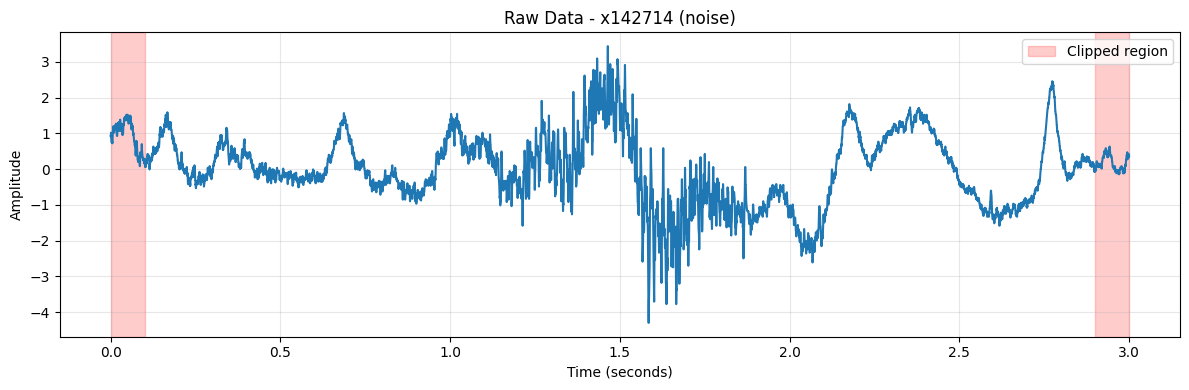


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.002568, Max: 1.161841, Mean: 0.205572
    0-  4 Hz: mean=0.479538, max=0.729121
    4-  8 Hz: mean=0.508233, max=1.033517
    8- 13 Hz: mean=0.165090, max=0.314961
   13- 30 Hz: mean=0.095577, max=0.267022
   30- 55 Hz: mean=0.152682, max=0.788950
   57- 63 Hz: mean=0.136088, max=0.599642
   65- 80 Hz: mean=0.117710, max=0.539434
   80-150 Hz: mean=0.184111, max=1.161841
  150-250 Hz: mean=0.117142, max=0.742308
  250-500 Hz: mean=0.099550, max=0.454217

PDM Statistics (absolute values):
  Global - Min: 0.002568, Max: 1.161841, Mean: 0.205572
    0-  4 Hz: mean=0.479538, max=0.729121
    4-  8 Hz: mean=0.508233, max=1.033517
    8- 13 Hz: mean=0.165090, max=0.314961
   13- 30 Hz: mean=0.095577, max=0.267022
   30- 55 Hz: mean=0.152682, max=0.788950
   57- 63 Hz: mean=0.136088, max=0.599642
   65- 80 Hz: mean=0.117710, max=0.539434
   80-150 Hz: mean=0.184111, max=1.161841
  150-250 Hz: mean=0.1

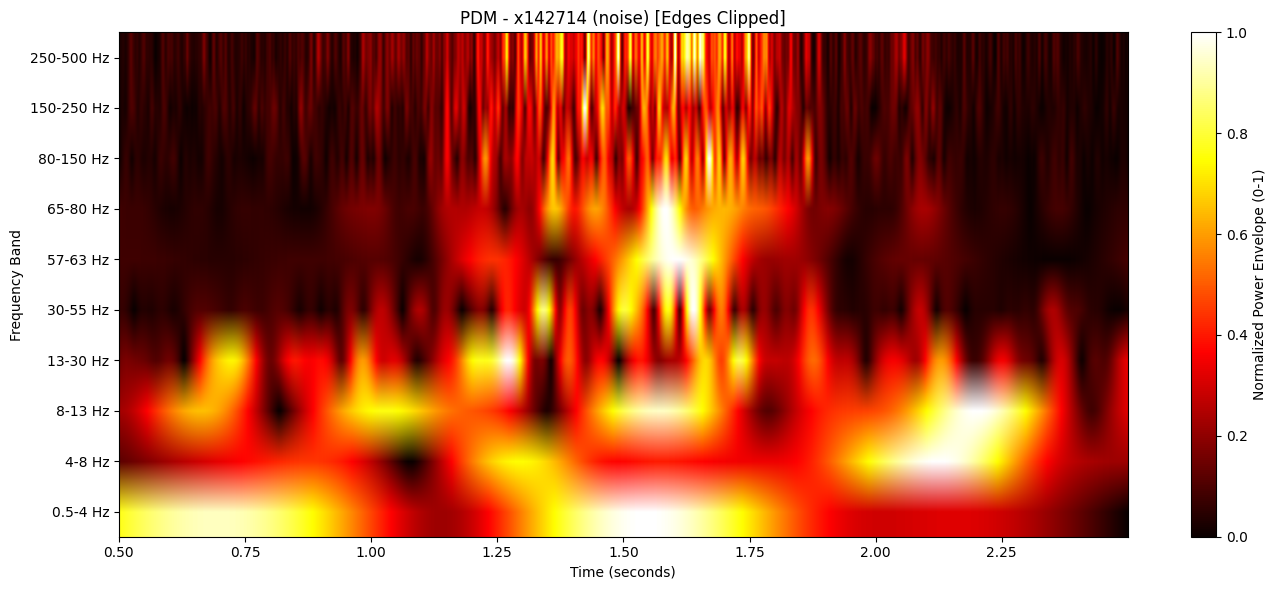

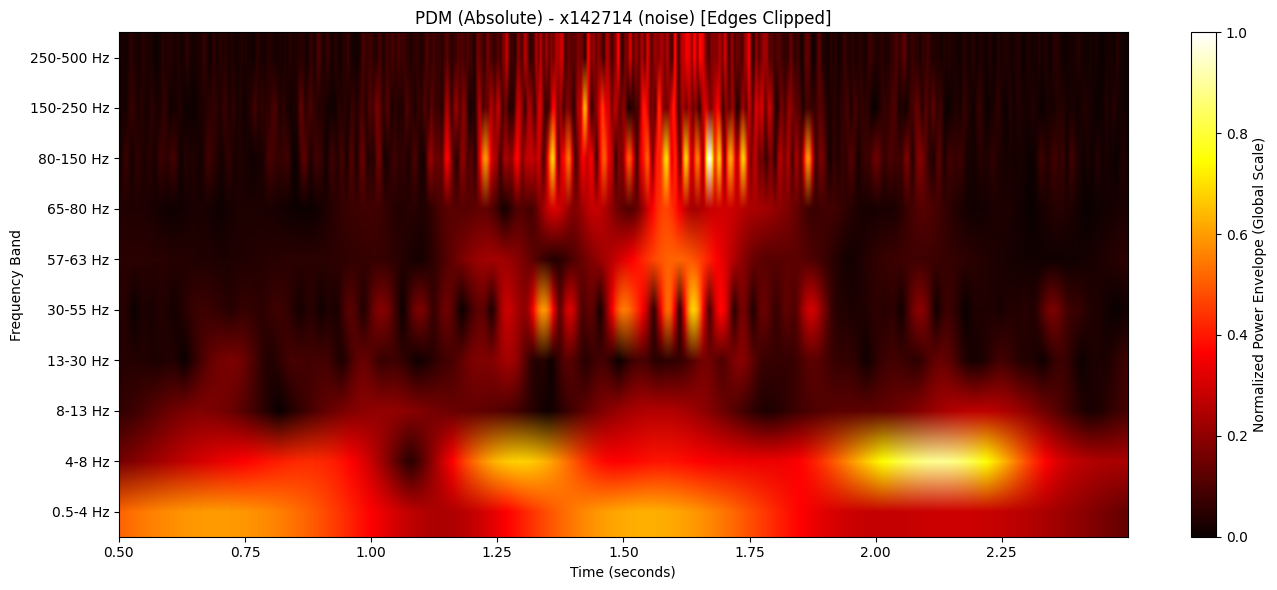

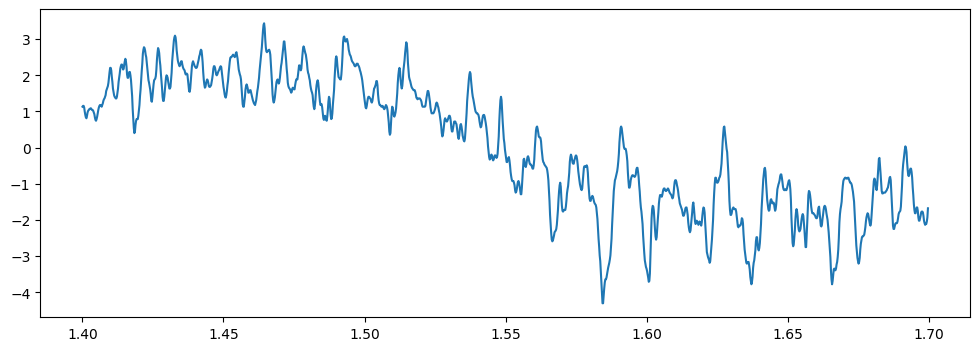

In [4]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, butter, sosfiltfilt
from scipy.ndimage import gaussian_filter1d

def compute_pdm_fixed(signal, fs, freq_bands, clip_seconds=0.5):
    """
    Compute Power Distribution Matrix with edge clipping
    
    Parameters:
    - clip_seconds: How many seconds to clip from each edge (default 0.5s)
    """
    n_samples = len(signal)
    n_bands = len(freq_bands)
    time = np.arange(n_samples) / fs
    
    # Calculate samples to clip
    clip_samples = int(clip_seconds * fs)
    
    pdm = np.zeros((n_bands, n_samples))
    
    for i, (low_freq, high_freq) in enumerate(freq_bands):
        nyquist = fs / 2
        low = max(low_freq / nyquist, 0.001)
        high = min(high_freq / nyquist, 0.999)
        
        if low >= high:
            continue
        
        # Use SOS for better numerical stability
        sos = butter(4, [low, high], btype='band', output='sos')
        filtered_signal = sosfiltfilt(sos, signal)
        
        # Compute envelope using Hilbert transform
        analytical_signal = hilbert(filtered_signal)
        envelope = np.abs(analytical_signal)
        
        # Smooth the envelope slightly
        envelope_smooth = gaussian_filter1d(envelope, sigma=10)
        
        pdm[i, :] = envelope_smooth
    
    # Clip edges
    if clip_samples > 0:
        pdm_clipped = pdm[:, clip_samples:-clip_samples]
        time_clipped = time[clip_samples:-clip_samples]
    else:
        pdm_clipped = pdm
        time_clipped = time
    
    return pdm_clipped, time_clipped

def plot_pdm_absolute(pdm, time, freq_bands, title="Power Distribution Matrix"):
    """Plot PDM with global normalization to show relative power"""
    
    print(f"\nPDM Statistics (absolute values):")
    print(f"  Global - Min: {pdm.min():.6f}, Max: {pdm.max():.6f}, Mean: {pdm.mean():.6f}")
    
    for i, (low, high) in enumerate(freq_bands):
        print(f"  {low:3.0f}-{high:3.0f} Hz: mean={pdm[i,:].mean():.6f}, max={pdm[i,:].max():.6f}")
    
    plt.figure(figsize=(14, 6))
    
    freq_labels = [f"{low}-{high} Hz" for low, high in freq_bands]
    
    global_min = pdm.min()
    global_max = pdm.max()
    pdm_normalized = (pdm - global_min) / (global_max - global_min)
    
    plt.imshow(pdm_normalized, aspect='auto', cmap='hot', interpolation='bilinear',
               extent=[time[0], time[-1], 0, len(freq_bands)], origin='lower')  # Added origin='lower'
    plt.colorbar(label='Normalized Power Envelope (Global Scale)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency Band')
    plt.yticks(np.arange(len(freq_bands)) + 0.5, freq_labels)
    plt.title(title)
    plt.tight_layout()

def plot_pdm_normalized(pdm, time, freq_bands, title="Power Distribution Matrix"):
    """Plot PDM with robust visualization"""
    
    # Print statistics
    print(f"\nPDM Statistics (after clipping):")
    print(f"  Shape: {pdm.shape}")
    print(f"  Time range: {time[0]:.2f}s to {time[-1]:.2f}s")
    print(f"  Min: {pdm.min():.6f}, Max: {pdm.max():.6f}, Mean: {pdm.mean():.6f}")
    
    # Check each frequency band
    for i, (low, high) in enumerate(freq_bands):
        print(f"  {low:3.0f}-{high:3.0f} Hz: mean={pdm[i,:].mean():.6f}, max={pdm[i,:].max():.6f}")
    
    plt.figure(figsize=(14, 6))
    
    freq_labels = [f"{low}-{high} Hz" for low, high in freq_bands]
    
    # Normalize each frequency band independently
    pdm_normalized = np.zeros_like(pdm)
    for i in range(pdm.shape[0]):
        row_min = pdm[i, :].min()
        row_max = pdm[i, :].max()
        if row_max > row_min:
            pdm_normalized[i, :] = (pdm[i, :] - row_min) / (row_max - row_min)
    
    plt.imshow(pdm_normalized, aspect='auto', cmap='hot', interpolation='bilinear',
               extent=[time[0], time[-1], 0, len(freq_bands)], origin='lower')  # Added origin='lower'
    plt.colorbar(label='Normalized Power Envelope (0-1)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency Band')
    plt.yticks(np.arange(len(freq_bands)) + 0.5, freq_labels)
    plt.title(title)
    plt.tight_layout()

# Frequency bands with specific 60Hz detection
freq_bands = [
    (0.5, 4),      # Delta
    (4, 8),        # Theta
    (8, 13),       # Alpha
    (13, 30),      # Beta
    (30, 55),      # Low Gamma
    (57, 63),      # **60 Hz POWERLINE**
    (65, 80),      # Mid Gamma
    (80, 150),     # High Gamma
    (150, 250),    # Ripple
    (250, 500),    # Fast Ripple
]

# Test on powerline data
print(df_noise["patient_id"].unique())
test_df = df_noise[df_noise["patient_id"]==20].head(1)

for idx, segment_df in test_df.iterrows():
    raw_path = "C:\\Users\\yuans\\Desktop\\Mayo_dataset\\DATASET_MAYO\\" + segment_df["segment_id"] + ".mat"
    mat = scipy.io.loadmat(raw_path)
    raw_data = mat["data"].flatten()
    
    print(f"\n{'='*60}")
    print(f"Processing: {segment_df['segment_id']} ({segment_df['category_name']})")
    print(f"Raw signal - Min: {raw_data.min():.2f}, Max: {raw_data.max():.2f}, Std: {raw_data.std():.2f}")
    
    # Plot raw data with clipping regions indicated
    plt.figure(figsize=(12, 4))
    time_full = np.arange(len(raw_data)) / 5000
    plt.plot(time_full, raw_data)
    
    # Show clipped regions
    clip_time = 0.1
    plt.axvspan(0, clip_time, alpha=0.2, color='red', label='Clipped region')
    plt.axvspan(time_full[-1] - clip_time, time_full[-1], alpha=0.2, color='red')
    
    plt.title(f"Raw Data - {segment_df['segment_id']} ({segment_df['category_name']})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Compute and plot PDM with clipping
    pdm, pdm_time = compute_pdm_fixed(raw_data, fs=5000, freq_bands=freq_bands, clip_seconds=0.5)
    plot_pdm_normalized(pdm, pdm_time, freq_bands, 
                   title=f"PDM - {segment_df['segment_id']} ({segment_df['category_name']}) [Edges Clipped]")
    plot_pdm_absolute(pdm, pdm_time, freq_bands, 
                   title=f"PDM (Absolute) - {segment_df['segment_id']} ({segment_df['category_name']}) [Edges Clipped]")
    plt.show()

    metadata = {
        "sampling_rate": 5000,
        # "category_name": segment_df["category_name"],
        "anatomy": segment_df["anatomy"],
        "channel": segment_df["channel"],
        "electrode_type": segment_df["electrode_type"],
        "soz": segment_df["soz"],
        "context": """Each data segment is described by clinical useful features: classification category 
        (power line interference; high frequency noise; pathological activity; physiological activity), 
        seizure onset zone (True, False), anatomical location, electrode type, reviewer identification number, patient number.
        In general, datasets contain data clips from four groups of distinctive events: 
        powerline noise (in our case 50 Hz or 60 Hz depending on power line frequency at clinic’s location); 
        muscle and machine artifacts (artifactual signals (like muscle artifacts) caused by patient movement or other physiological sources commonly 
        share features with pathological signals, e.g. power in band 200–600 Hz.); 
        physiological iEEG activity in different behavioral states of subject (sleep/wake/wake-relax); 
        pathophysiological activity we are targeting identification of signal graphoelements and 
        thus defining pathological signal group as signals with epileptiform graphoelements e.g.: HFOs and spikes or epileptiform discharges.
        Mayo Clinic data were recorded during the first night after electrode implantation and consisted of two-hour long iEEG recordings. 
        The data were collected between 1 AM and 3 AM from 25 patients with DRE undergoing evaluation for epilepsy surgery. 
        The Neuralynx Cheetah system (Neuralynx Inc., Bozeman MT, USA) was used to acquire the data at sampling rate of 32 kHz with 
        hardware filter bandwidth of DC – 9 kHz. Similar to St’ Anne’s recordings, all data were filtered by an antialiasing filter, 
        but in this case with cutoff frequency of 1 kHz. The data was subsequently down-sampled to 5 kHz. 
        Patients were implanted with either depth electrodes or grids and strips, or the combination. 
        The depth electrodes used in the dataset were AD-Tech electrodes (AD-Tech Medical Instrument Corp., Racine, WI or PMT, Chahassen, MN, USA) 
        and consisted of 4 or 8 Platinum/Iridium contacts (2.3 mm long, 1 mm diameter, spaced 5 or 10 mm center-to-center). 
        AD-Tech subdural grids and strips electrodes had 4.0 mm diameter Platinum/Iridium discs (2.3 mm exposed) with 10 mm center-to-center distance.
        All data were reviewed in SignalPlant18, a free software tool for signal processing, inspection and annotation. 
        The dataset was annotated by 3 reviewers, where each recording was reviewed by single reviewer. 
        Each recording was visually reviewed in time domain alongside power distribution matrices (PDM) for manual artifact detection13. 
        The PDM method estimates the signal power envelope by data filtering in specific frequency bands, 
        and further computes the absolute value of the analytical signal (analytical signal is complex signal comprising original signal in the real domain 
        and its Hilbert transform in imaginary domain) to obtain the signal envelope. Visual inspection of the PDM allow for fast localization of high-power 
        events appearing across all channels and are likely to be artifacts. The signal regions with high power envelope were subsequently reviewed in the 
        time domain to classify signals into pathological/artifactual group. 
        If Pathology and powerline boise are booth detected, the segment is labeled as Pathology."""
    }

    #plot raw data from second 1.5 to 1.6
    plt.figure(figsize=(12, 4))
    start_time = 1.4
    end_time = 1.7
    start_sample = int(start_time * 5000)
    end_sample = int(end_time * 5000)
    time_zoom = np.arange(start_sample, end_sample) / 5000
    plt.plot(time_zoom, raw_data[start_sample:end_sample])

In [5]:
# # ---------- 12. Example usage ----------

# if __name__ == "__main__":
#     app = build_inspection_graph()

#     def safe_serialize(obj):
#         if hasattr(obj, "model_dump"):
#             return safe_serialize(obj.model_dump())
#         if isinstance(obj, np.ndarray):
#             return f"np.ndarray(shape={obj.shape})"
#         if isinstance(obj, list):
#             if len(obj) > 50:   # truncate long lists
#                 return f"[...{len(obj)} items...]"
#             return [safe_serialize(v) for v in obj]
#         if isinstance(obj, dict):
#             return {k: safe_serialize(v) for k, v in obj.items()}
#         return obj

#     print("=== DEBUG STREAM OF PIPELINE ===")

#     # Synthetic neural data 
#     initial_state: InspectionState = {
#         "goal": "initial inspection of data to identify noise/artifact and determine which one of the four category the segment is best described by",
#         "raw_data": raw_data,
#         "metadata": metadata
#     }

#     for event in app.stream(initial_state):
#         print("\n--- NODE:", event["node"] if "node" in event else "UNKNOWN", "---")
#         print(json.dumps(safe_serialize(event), indent=2))




In [ ]:
if __name__ == "__main__":
    app = build_inspection_graph()

    # select 10 random segments from each category
    test_df = pd.concat([
        df_noise.sample(10), 
        df_physiology.sample(10), 
        df_pathology.sample(10), 
        df_powerline.sample(10)
    ]).reset_index(drop=True)

    # create a result dataframe to store results
    results = []

    for idx, segment_df in test_df.iterrows():
        print(f"\n{'='*60}")
        print(f"Processing {idx+1}/{len(test_df)}: {segment_df['segment_id']}")
        print(f"Ground truth: {segment_df['category_name']}")
        print(f"{'='*60}")
        
        try:
            mat = scipy.io.loadmat(
                "C:\\Users\\yuans\\Desktop\\Mayo_dataset\\DATASET_MAYO\\" + 
                segment_df["segment_id"] + ".mat"
            )
            raw_data = mat["data"].flatten()

            metadata = {
                "sampling_rate": 5000,
                "anatomy": segment_df["anatomy"],
                "channel": segment_df["channel"],
                "electrode_type": segment_df["electrode_type"],
                "soz": segment_df["soz"],
                "context": """Each data segment is described by clinical useful features: classification category 
                (power line interference; high frequency noise; pathological activity; physiological activity), 
                seizure onset zone (True, False), anatomical location, electrode type, reviewer identification number, patient number.
                In general, datasets contain data clips from four groups of distinctive events: 
                powerline noise (in our case 50 Hz or 60 Hz depending on power line frequency at clinic's location); 
                muscle and machine artifacts (artifactual signals (like muscle artifacts) caused by patient movement or other physiological sources commonly 
                share features with pathological signals, e.g. power in band 200–600 Hz.); 
                physiological iEEG activity in different behavioral states of subject (sleep/wake/wake-relax); 
                pathophysiological activity we are targeting identification of signal graphoelements and 
                thus defining pathological signal group as signals with epileptiform graphoelements e.g.: HFOs and spikes or epileptiform discharges.
                Mayo Clinic data were recorded during the first night after electrode implantation and consisted of two-hour long iEEG recordings. 
                The data were collected between 1 AM and 3 AM from 25 patients with DRE undergoing evaluation for epilepsy surgery. 
                The Neuralynx Cheetah system (Neuralynx Inc., Bozeman MT, USA) was used to acquire the data at sampling rate of 32 kHz with 
                hardware filter bandwidth of DC – 9 kHz. Similar to St' Anne's recordings, all data were filtered by an antialiasing filter, 
                but in this case with cutoff frequency of 1 kHz. The data was subsequently down-sampled to 5 kHz. 
                Patients were implanted with either depth electrodes or grids and strips, or the combination. 
                The depth electrodes used in the dataset were AD-Tech electrodes (AD-Tech Medical Instrument Corp., Racine, WI or PMT, Chahassen, MN, USA) 
                and consisted of 4 or 8 Platinum/Iridium contacts (2.3 mm long, 1 mm diameter, spaced 5 or 10 mm center-to-center). 
                AD-Tech subdural grids and strips electrodes had 4.0 mm diameter Platinum/Iridium discs (2.3 mm exposed) with 10 mm center-to-center distance.
                All data were reviewed in SignalPlant18, a free software tool for signal processing, inspection and annotation. 
                The dataset was annotated by 3 reviewers, where each recording was reviewed by single reviewer. 
                Each recording was visually reviewed in time domain alongside power distribution matrices (PDM) for manual artifact detection13. 
                The PDM method estimates the signal power envelope by data filtering in specific frequency bands, 
                and further computes the absolute value of the analytical signal (analytical signal is complex signal comprising original signal in the real domain 
                and its Hilbert transform in imaginary domain) to obtain the signal envelope. Visual inspection of the PDM allow for fast localization of high-power 
                events appearing across all channels and are likely to be artifacts. The signal regions with high power envelope were subsequently reviewed in the 
                time domain to classify signals into pathological/artifactual group. 
                If Pathology and powerline noise are both detected, the segment is labeled as Pathology."""
            }
            
            initial_state: InspectionState = {
                "goal": "initial inspection of data to identify noise/artifact and determine which one of the four category the segment is best described by",
                "raw_data": raw_data,
                "metadata": metadata
            }
            def extract_result_safely(result):
                """Extract category, confidence, and rationale from result, handling various formats"""
                try:
                    goal_output = result["goal_output"]
                    
                    # Convert Pydantic models to dict
                    def to_dict(obj):
                        if hasattr(obj, "model_dump"):
                            return obj.model_dump()
                        elif hasattr(obj, "dict"):
                            return obj.dict()
                        elif isinstance(obj, dict):
                            return obj
                        else:
                            return dict(obj)
                    
                    goal_output_dict = to_dict(goal_output)
                    
                    # Handle nested goal_output
                    if "goal_output" in goal_output_dict:
                        result_data = goal_output_dict["goal_output"]["result"]
                    else:
                        result_data = goal_output_dict["result"]
                    
                    return {
                        "category": result_data["category"],
                        "confidence": result_data.get("confidence", None),
                        "rationale": result_data.get("rationale", "")
                    }
                except Exception as e:
                    print(f"\nDEBUG - Error extracting result:")
                    print(f"  Error: {e}")
                    print(f"  Result keys: {result.keys()}")
                    print(f"  Goal output type: {type(result.get('goal_output'))}")
                    if 'goal_output' in result:
                        print(f"  Goal output: {result['goal_output']}")
                    raise

            print("Executing pipeline...")
            result = app.invoke(initial_state)
            extracted = extract_result_safely(result)

            agent_result = extracted["category"]
            confidence = extracted["confidence"]
            rationale = extracted["rationale"]

            print(f"Agent result: {agent_result} (confidence: {confidence})")
            
            # Store results
            results.append({
                "segment_id": segment_df["segment_id"],
                "agent_result": agent_result,
                "ground_truth": segment_df["category_name"]
            })
            
        except Exception as e:
            print(f"ERROR processing {segment_df['segment_id']}: {e}")
            results.append({
                "segment_id": segment_df["segment_id"],
                "agent_result": "ERROR",
                "ground_truth": segment_df["category_name"]
            })
            continue

    # Create results dataframe
    result_df = pd.DataFrame(results)
    
    # Remove any error rows for accuracy calculation
    result_df_clean = result_df[result_df["agent_result"] != "ERROR"]
    
    print(f"\n{'='*60}")
    print("=== FINAL RESULTS ===")
    print(f"{'='*60}")
    
    # Calculate overall accuracy
    correct_predictions = result_df_clean[
        result_df_clean["agent_result"] == result_df_clean["ground_truth"]
    ]
    accuracy = len(correct_predictions) / len(result_df_clean)
    print(f"\nOverall Accuracy: {accuracy*100:.2f}% ({len(correct_predictions)}/{len(result_df_clean)})")
    
    # Calculate accuracy per category
    print("\nPer-Category Accuracy:")
    categories = result_df_clean["ground_truth"].unique()
    for category in categories:
        category_df = result_df_clean[result_df_clean["ground_truth"] == category]
        correct = category_df[category_df["agent_result"] == category_df["ground_truth"]]
        cat_accuracy = len(correct) / len(category_df)
        print(f"  {category:25s}: {cat_accuracy*100:.2f}% ({len(correct)}/{len(category_df)})")
    
    # Show confusion matrix
    print("\nConfusion Matrix:")
    print(result_df_clean.groupby(["ground_truth", "agent_result"]).size().unstack(fill_value=0))
    
    # Save results
    result_df.to_csv("agent_classification_results.csv", index=False)
    print("\nResults saved to: agent_classification_results.csv")


Processing 1/40: x030605
Ground truth: noise
Executing pipeline...
Agent result: powerline_noise (confidence: 0.85)

Processing 2/40: x028759
Ground truth: noise
Executing pipeline...
Agent result: powerline_noise (confidence: 0.85)

Processing 2/40: x028759
Ground truth: noise
Executing pipeline...
Agent result: physiological activity (confidence: 0.85)

Processing 3/40: x000665
Ground truth: noise
Executing pipeline...
Agent result: physiological activity (confidence: 0.85)

Processing 3/40: x000665
Ground truth: noise
Executing pipeline...


In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Failed to display graph: {str(e)}")